In [1]:
import pandas as pd
import numpy as np

# IO

In [2]:
from PineBioML.preprocessing import IO

In [3]:
# Path
input_folder = "./input/"
output_folder = "./output/"
export_title = "example_basic "

In [4]:
##### Read data method 1: read single file
##### index_col is the column of index of samples (or sample name).
##### If your data do not have such column, please set index_col=None
data = IO.read_file(input_folder+ "example_data.xlsx", index_col=0)

##### pick the target label column
y = data["y"]

##### drop the target from dataframe, using the remaining to predict y (the target)
x = data.drop("y", axis = 1)

In [5]:
##### Read data method 2: read multiple files
x, y = IO.read_multiple_files(
    file_path_list=[
        input_folder+ "example_group1.csv", # all samples from this file will have y = 0, because it is in the 1st place of the file path list.
        input_folder+ "example_group2.tsv", # all samples from this file will have y = 1, because it is in the 2nd place of the file path list.
    ],
    index_col=0
    )

In [6]:
x.head(5)

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature90,feature91,feature92,feature93,feature94,feature95,feature96,feature97,feature98,feature99
0,-0.046497,-0.936589,0.831728,0.676612,1.089821,1.182193,0.057498,1.087513,0.916977,1.366645,...,-0.906979,0.557050,-0.052619,-0.777292,1.332989,0.586623,0.755015,0.568341,0.557208,-0.301866
1,1.375768,2.982642,0.828336,0.331314,0.780520,0.077063,-0.180034,0.720076,-0.293831,1.130501,...,1.706683,0.370087,-1.770032,1.021724,-1.395205,1.358890,-0.242389,-1.181098,-1.395800,-1.978847
2,0.513176,-0.237153,0.403565,0.340722,-0.969333,1.181883,-1.853352,0.954555,0.102275,-0.966393,...,-0.287969,0.243530,-0.684112,0.179854,-1.024727,0.962608,-0.246234,-1.125735,-1.121738,-0.757847
3,-0.113984,0.570842,-1.447456,0.478515,-1.063417,-0.928786,-0.903156,-0.163331,-0.231151,0.136662,...,-0.299377,1.624747,0.046088,-0.585543,-2.059056,-0.872338,-0.491621,-0.383596,1.557598,-0.923839
4,1.338395,1.014111,-0.231040,0.188683,1.030870,0.233220,1.318331,-1.253098,-2.084681,0.360878,...,-0.284378,-0.145813,-0.264684,0.399323,0.629979,0.410857,-1.790606,-0.511627,0.539162,1.026244


In [7]:
y.head(5)

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
dtype: float64

# Preprocessing

In [8]:
### within sample normalization
#x = x.T
#x = (x-x.mean())/x.std()
#x = x.T

### standarization
x = (x-x.mean())/x.std()

In [9]:
# Impute 0
from PineBioML.preprocessing import impute

# The imputer will drop the features with missing value more than 60%.
# Remaining will be filled by 0.
simple = impute.simple_imputer(threshold = 0.6, strategy = "constant")
x, y = simple.fit_transform(x, y)

# Data overview

In [10]:
import PineBioML.report.utils as report_utils

The x consists of of 1 useful feature and 99 garbage features.

start PCA
start PLS
start UMAP


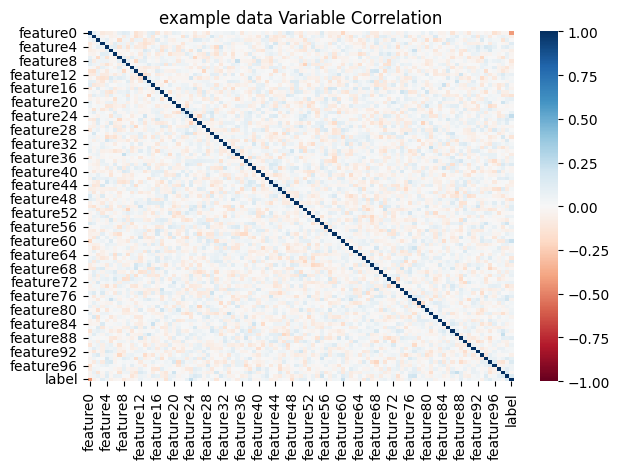

example data PCA Scatter plot


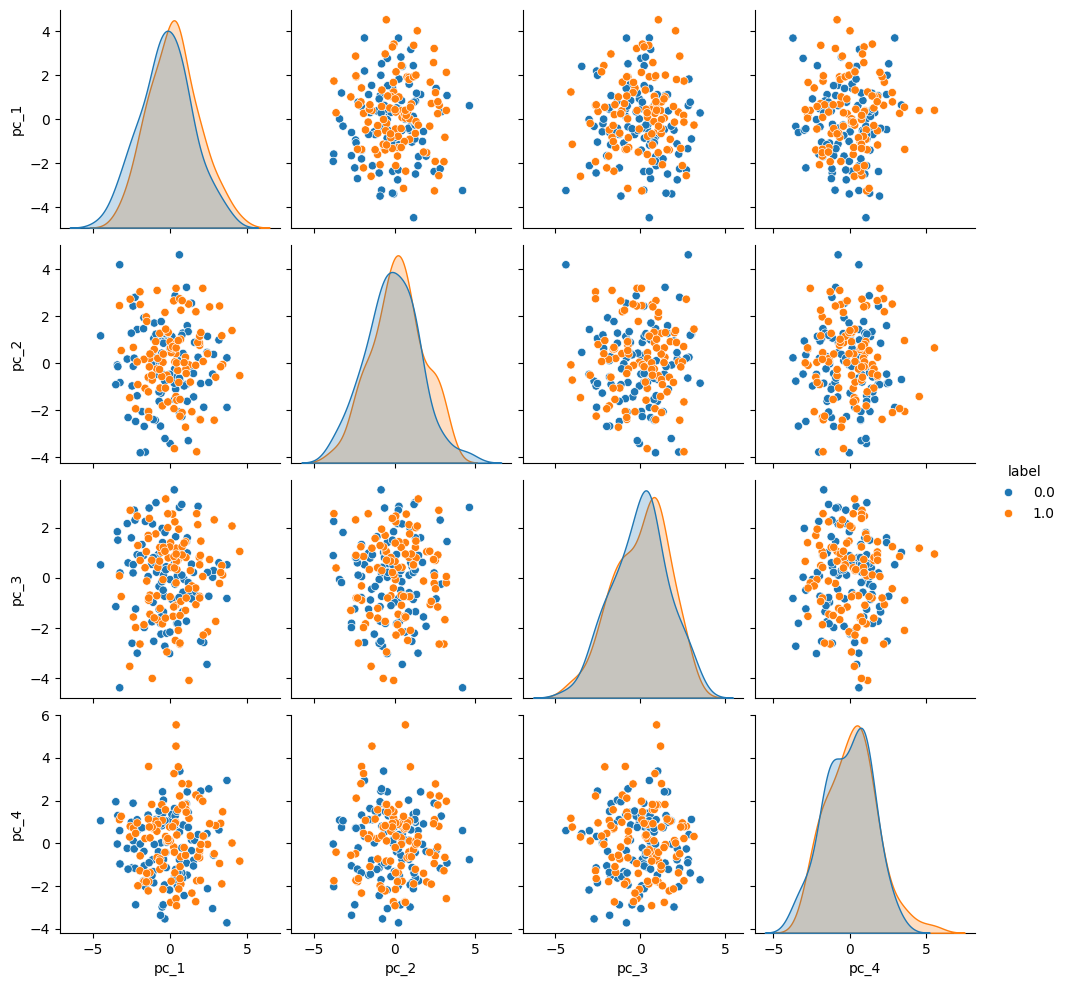

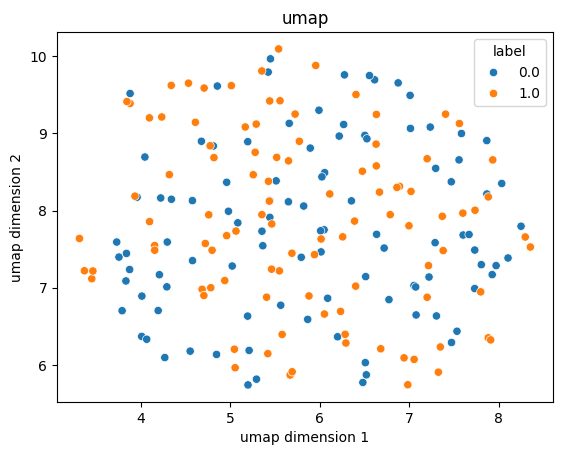

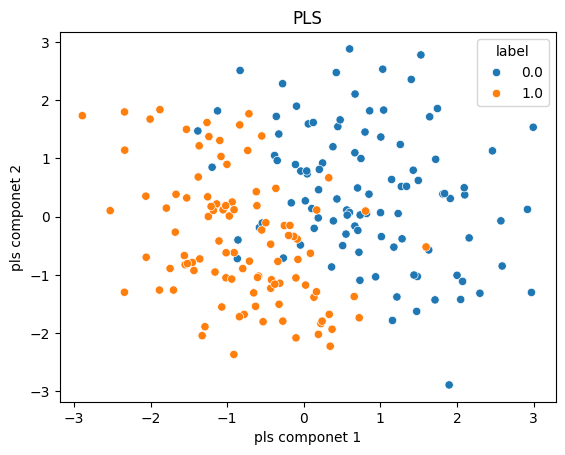

In [11]:
report_utils.data_overview(x, y, label_name = "label", title= "example data")

# Feature selection

In [12]:
from PineBioML.selection.ensemble import selector

In [13]:
# Use several way to select top-k important features, which includes decision tree, random forest, lasso, multi lasso, svm, adaboost, xgboost
ensemble_selector = selector()
important_feature, importance = ensemble_selector.Select(x, y, k = 20) # if k = -1, it returns all the feature scores

Using  c45  to select.


100%|██████████| 100/100 [00:00<00:00, 434.85it/s]


c45  is done.

Using  RF_gini  to select.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1024 out of 1024 | elapsed:    0.8s finished
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


RF_gini  is done.

Using  AdaBoost  to select.
I don't have a progress bar but I am running
AdaBoost  is done.

Using  Lasso_Bisection  to select.
Lasso_Bisection  is done.

Using  multi_Lasso  to select.
multi_Lasso  is done.

Using  SVM  to select.
SVM  is done.

Using  XGboost  to select.
XGboost  is done.

Using  Lightgbm  to select.
[LightGBM] [Info] Number of positive: 100, number of negative: 100
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6829
[LightGBM] [Info] Number of data points in the train set: 200, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [14]:
# The features that was selected by ML algoritms.
important_feature

,DT_score_c45,RandomForest_gini,AdaBoost128,LassoLinear,multi_Lasso,SVM,XGboost,Lightgbm
0,feature0,feature0,feature0,feature0,feature0,feature0,feature95,feature0
1,feature11,feature24,feature24,feature24,feature24,feature18,feature0,feature18
2,feature59,feature60,feature66,feature18,feature18,feature66,feature60,feature60
3,feature88,feature66,feature18,feature66,feature60,feature24,feature76,feature38
4,feature36,feature48,feature60,feature60,feature48,feature47,feature66,feature11
5,feature25,feature18,feature38,feature95,feature66,feature95,feature5,feature24
6,feature27,feature38,NaN,feature30,feature8,feature34,feature10,feature65
7,feature35,feature30,NaN,feature51,feature88,feature76,feature38,feature95
8,feature46,feature59,NaN,feature88,feature76,feature43,feature29,feature66
9,feature60,feature88,NaN,feature16,feature3,feature27,feature44,feature47


In [15]:
# The feature importance given by diffirent methods.
# Please Notice that the score between diffirent methods is not comparable.
importance

,DT_score_c45,RandomForest_gini,AdaBoost128,LassoLinear,multi_Lasso,SVM,XGboost,Lightgbm
feature0,0.069869,0.078257,0.781250,0.170455,0.149398,0.062260,0.032218,95.0
feature11,0.033512,0.011240,NaN,NaN,NaN,NaN,NaN,16.0
feature59,0.032971,0.013188,NaN,NaN,NaN,NaN,0.017908,NaN
feature88,0.032788,0.012714,NaN,0.011126,0.009941,NaN,NaN,NaN
feature36,0.031090,NaN,NaN,NaN,NaN,NaN,NaN,NaN
feature25,0.030408,NaN,NaN,NaN,0.003081,NaN,NaN,NaN
feature27,0.030115,NaN,NaN,NaN,NaN,0.019073,NaN,NaN
feature35,0.030083,NaN,NaN,NaN,0.006770,NaN,NaN,NaN
feature46,0.029402,NaN,NaN,NaN,NaN,NaN,NaN,NaN
feature60,0.029305,0.022180,0.023438,0.028461,0.018804,NaN,0.027100,17.0


In [16]:
# merging importance from diffirent feature by z-score.
merge_importance = ((importance-importance.mean())/importance.std()).mean(axis = 1).sort_values(ascending=False)
merge_importance

feature0     3.475797
feature24    0.531978
feature10    0.429697
feature95    0.285272
feature66    0.195908
feature60    0.120939
feature18    0.107631
feature36   -0.062510
feature11   -0.063597
feature5    -0.105539
feature47   -0.117556
feature76   -0.152455
feature88   -0.173142
feature34   -0.205235
feature27   -0.215457
feature38   -0.240854
feature46   -0.246733
feature35   -0.252020
feature48   -0.255059
feature33   -0.263081
feature13   -0.264263
feature8    -0.269346
feature65   -0.289199
feature25   -0.289681
feature74   -0.291774
feature41   -0.304176
feature30   -0.306792
feature73   -0.342055
feature15   -0.349053
feature44   -0.349674
feature23   -0.351515
feature59   -0.352355
feature29   -0.355224
feature4    -0.369797
feature3    -0.378575
feature43   -0.378699
feature19   -0.394076
feature91   -0.400906
feature70   -0.424355
feature99   -0.426850
feature50   -0.435682
feature12   -0.439353
feature67   -0.454749
feature75   -0.482043
feature53   -0.505469
feature49 

### Choosing the top-5 feature to build models

In [17]:
x = x[merge_importance.index[:5]]

start PCA
start PLS
start UMAP


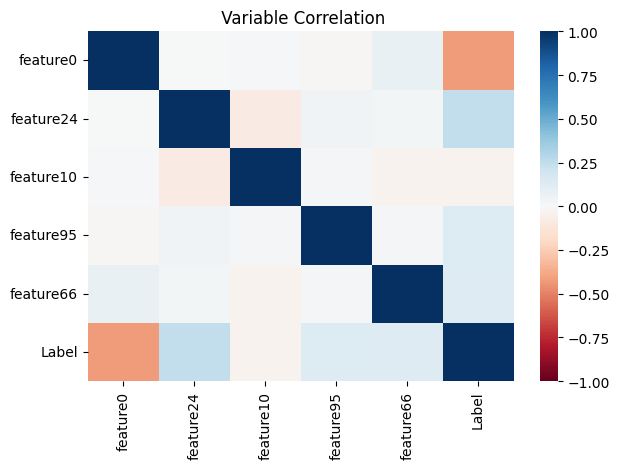

 PCA Scatter plot


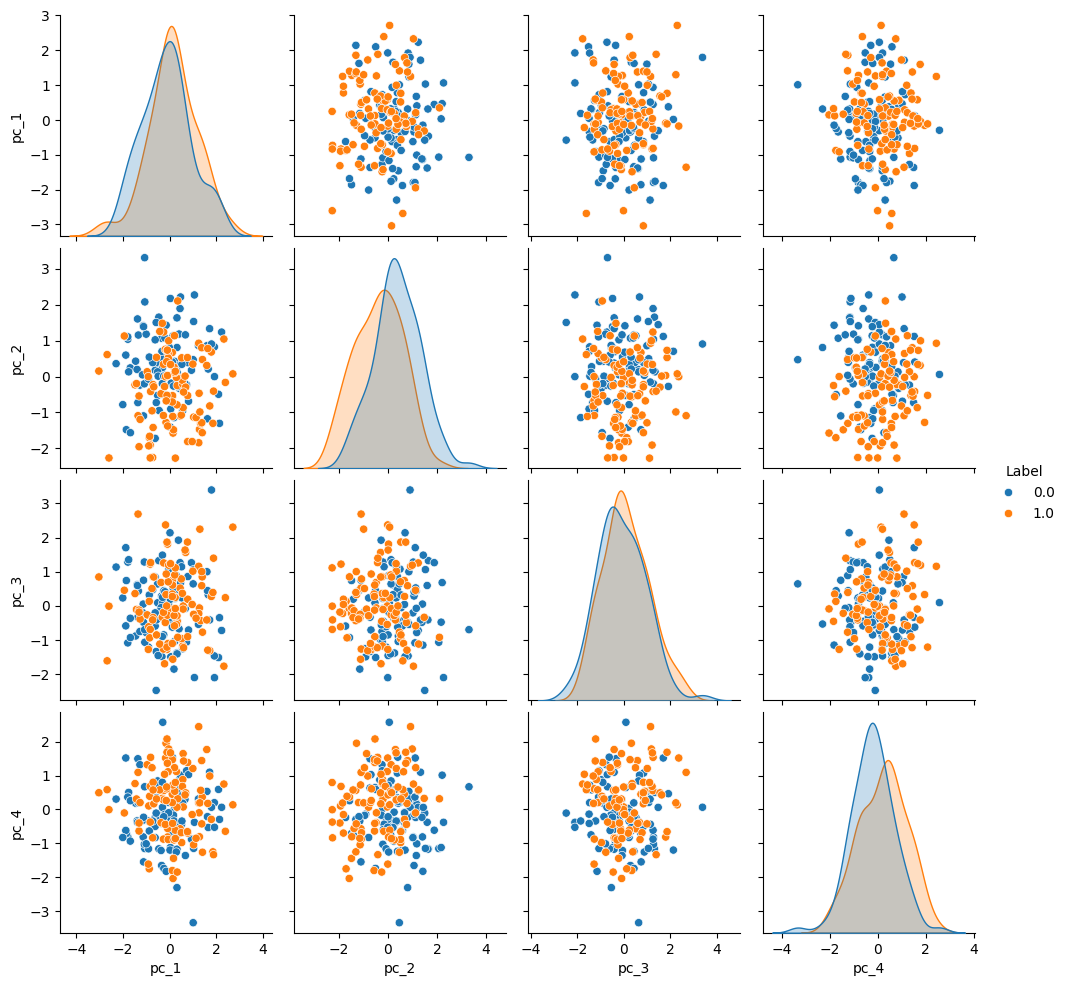

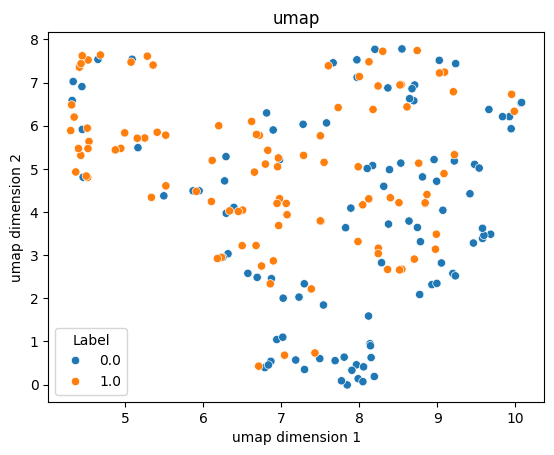

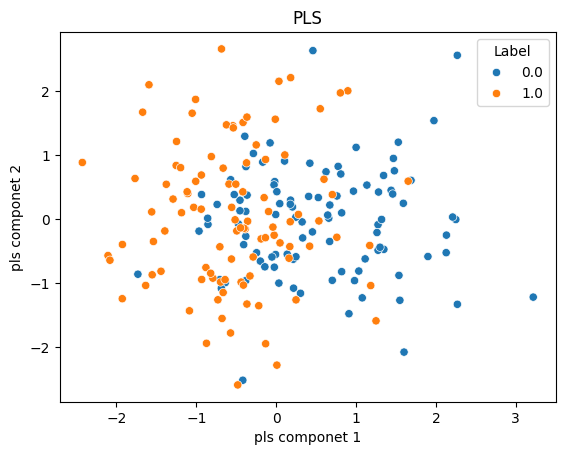

In [18]:
# Overviewing the top-5 features.
report_utils.data_overview(x, y, label_name = "Label")

# Modeling

### Train test split

In [19]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x[merge_importance.index[:5]], y, test_size=0.33, random_state=142, shuffle=True)

### Tuning a model

In [20]:
import PineBioML.model.supervised.Classification as tuner

start tuning. it will take a while.
best trial:  13   |  optuna seed:  71   |  model seed:  7837
best parameters:  {'n_estimators': 168, 'max_depth': 2, 'min_samples_split': 16, 'min_samples_leaf': 8, 'ccp_alpha': 0.012823087488905528, 'max_samples': 0.5623473939385397}

 
              precision    recall  f1-score   support

         0.0       0.69      0.61      0.65        33
         1.0       0.65      0.73      0.69        33

    accuracy                           0.67        66
   macro avg       0.67      0.67      0.67        66
weighted avg       0.67      0.67      0.67        66



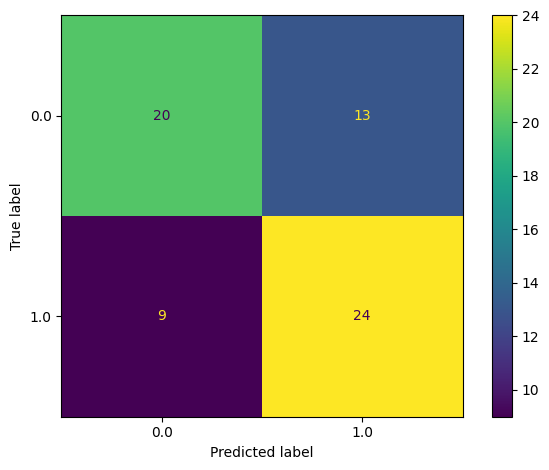

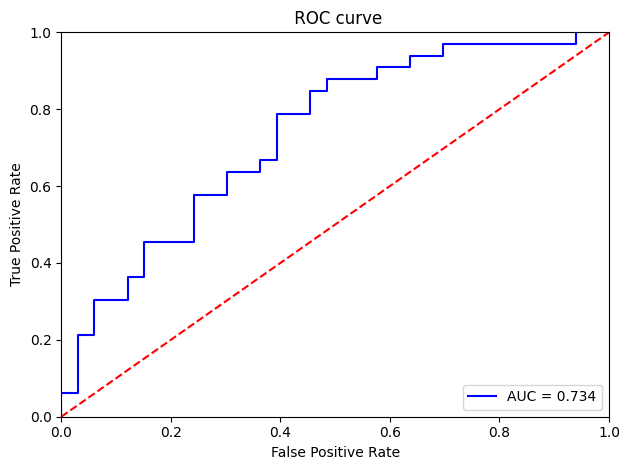

In [21]:
rf = tuner.RandomForest_tuner(x_train, y_train, target="roc_auc").tune()
rf.fit(x_train, y_train)
report_utils.classification_summary(y_valid ,rf.predict_proba(x_valid)[:, 1]) 

start tuning. it will take a while.
best trial:  33   |  optuna seed:  71   |  model seed:  12310
best parameters:  {'svc_c': 0.2553819209500787}

 
              precision    recall  f1-score   support

         0.0       0.68      0.58      0.62        33
         1.0       0.63      0.73      0.68        33

    accuracy                           0.65        66
   macro avg       0.66      0.65      0.65        66
weighted avg       0.66      0.65      0.65        66



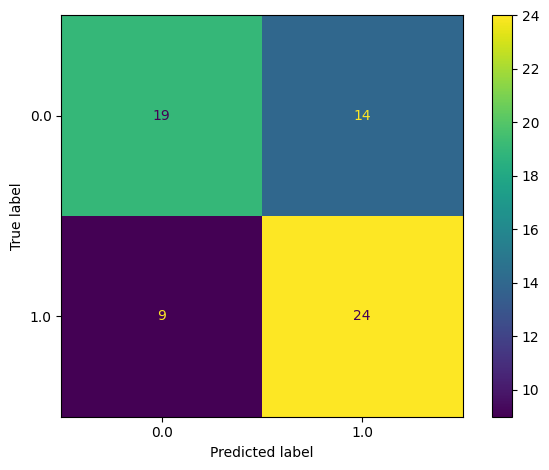

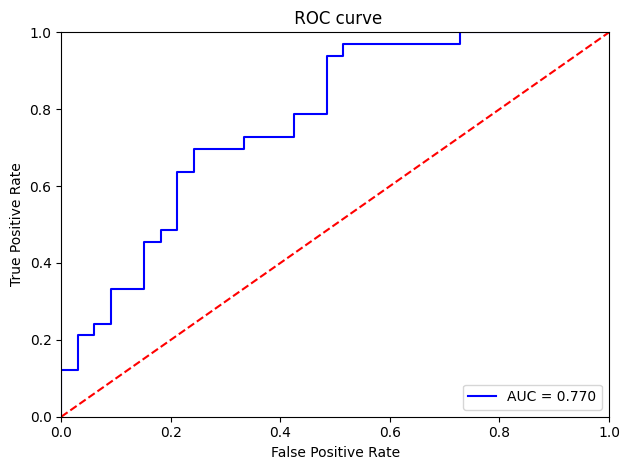

In [22]:
svm = tuner.SVC_tuner(x_train, y_train, target="f1").tune()
svm.fit(x_train, y_train)
report_utils.classification_summary(y_valid, svm.predict_proba(x_valid)[:, 1]) 

Logistic Regression with:  elasticnet  penalty,  saga  solver.
start tuning. it will take a while.
best trial:  38   |  optuna seed:  71   |  model seed:  2424
best parameters:  {'C': 5.319222979287218, 'l1_ratio': 0.5045685127788063}

 
              precision    recall  f1-score   support

         0.0       0.73      0.73      0.73        33
         1.0       0.73      0.73      0.73        33

    accuracy                           0.73        66
   macro avg       0.73      0.73      0.73        66
weighted avg       0.73      0.73      0.73        66



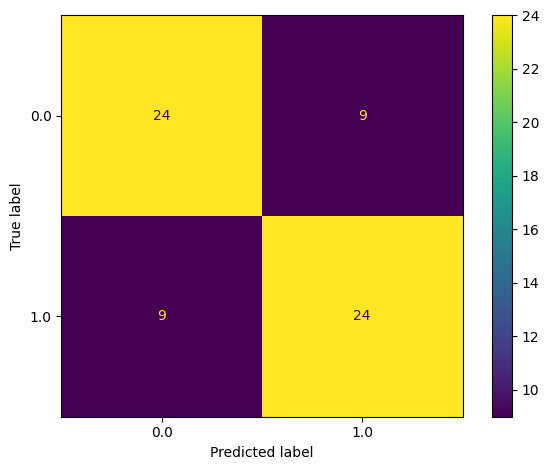

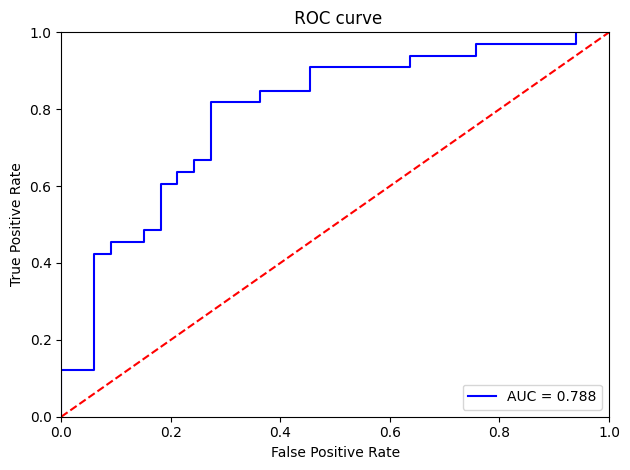

In [23]:
elasticnet = tuner.ElasticNet_tuner(x_train, y_train, target="neg_log_loss").tune()
elasticnet.fit(x_train, y_train)
report_utils.classification_summary(y_valid, elasticnet.predict_proba(x_valid)[:, 1]) 

### Mljar

C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


AutoML directory: ./output/MLjar
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Linear', 'Random Forest', 'LightGBM', 'Xgboost', 'CatBoost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'ensemble']
* Step simple_algorithms will try to check up to 1 model


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LinearAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LinearAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LinearAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
LinearAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LinearAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'
1_Linear logloss 0.579882 trained in 3.7 seconds (1-sample predict time 0.0158 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

* Step default_algorithms will try to check up to 5 models
LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

2_Default_LightGBM logloss 0.602941 trained in 3.11 seconds (1-sample predict time 0.0222 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


There was an error during 3_Default_Xgboost training.
Please check ./output/MLjar\errors.md for details.
CatBoostAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


CatBoostAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


CatBoostAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


CatBoostAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


CatBoostAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

4_Default_CatBoost logloss 0.632908 trained in 5.55 seconds (1-sample predict time 0.0255 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

5_Default_NeuralNetwork logloss 0.759615 trained in 4.32 seconds (1-sample predict time 0.021 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\supervised\utils\learning_curves.py:112: FutureWarning: The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\supervised\utils\learning_curves.py:112: FutureWarning: The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\supervised\utils\learning_curves.py:112: FutureWarning: The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise Valu

RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

6_Default_RandomForest logloss 0.576438 trained in 6.01 seconds (1-sample predict time 0.0922 seconds)
* Step not_so_random will try to check up to 20 models
LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

10_LightGBM logloss 0.632114 trained in 3.83 seconds (1-sample predict time 0.0163 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


There was an error during 6_Xgboost training.
Please check ./output/MLjar\errors.md for details.
CatBoostAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


CatBoostAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


CatBoostAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


CatBoostAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


CatBoostAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

14_CatBoost logloss 0.633939 trained in 9.46 seconds (1-sample predict time 0.0191 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

18_RandomForest logloss 0.558742 trained in 5.08 seconds (1-sample predict time 0.0561 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

22_NeuralNetwork logloss 1.074037 trained in 3.31 seconds (1-sample predict time 0.017 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\supervised\utils\learning_curves.py:112: FutureWarning: The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\supervised\utils\learning_curves.py:112: FutureWarning: The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\supervised\utils\learning_curves.py:112: FutureWarning: The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise Valu

LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

11_LightGBM logloss 0.600869 trained in 3.22 seconds (1-sample predict time 0.0147 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


There was an error during 7_Xgboost training.
Please check ./output/MLjar\errors.md for details.
CatBoostAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


CatBoostAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


CatBoostAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


CatBoostAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


CatBoostAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

15_CatBoost logloss 0.627202 trained in 4.85 seconds (1-sample predict time 0.0164 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

19_RandomForest logloss 0.550332 trained in 8.96 seconds (1-sample predict time 0.1707 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

23_NeuralNetwork logloss 0.759939 trained in 3.67 seconds (1-sample predict time 0.0167 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\supervised\utils\learning_curves.py:112: FutureWarning: The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\supervised\utils\learning_curves.py:112: FutureWarning: The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\supervised\utils\learning_curves.py:112: FutureWarning: The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise Valu

LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

12_LightGBM logloss 0.60182 trained in 3.36 seconds (1-sample predict time 0.016 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


There was an error during 8_Xgboost training.
Please check ./output/MLjar\errors.md for details.
CatBoostAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


CatBoostAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


CatBoostAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


CatBoostAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
CatBoostAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

16_CatBoost logloss 0.614469 trained in 4.35 seconds (1-sample predict time 0.025 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

20_RandomForest logloss 0.577218 trained in 6.53 seconds (1-sample predict time 0.0581 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

24_NeuralNetwork logloss 0.949399 trained in 3.59 seconds (1-sample predict time 0.016 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\supervised\utils\learning_curves.py:112: FutureWarning: The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\supervised\utils\learning_curves.py:112: FutureWarning: The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\supervised\utils\learning_curves.py:112: FutureWarning: The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise Valu

LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

13_LightGBM logloss 0.602941 trained in 4.14 seconds (1-sample predict time 0.013 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


There was an error during 9_Xgboost training.
Please check ./output/MLjar\errors.md for details.
CatBoostAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


CatBoostAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


CatBoostAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


CatBoostAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


CatBoostAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

17_CatBoost logloss 0.612766 trained in 4.74 seconds (1-sample predict time 0.019 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

21_RandomForest logloss 0.59088 trained in 5.49 seconds (1-sample predict time 0.0676 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

25_NeuralNetwork logloss 1.454856 trained in 3.4 seconds (1-sample predict time 0.023 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\supervised\utils\learning_curves.py:112: FutureWarning: The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\supervised\utils\learning_curves.py:112: FutureWarning: The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\supervised\utils\learning_curves.py:112: FutureWarning: The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise Valu

* Step golden_features will try to check up to 3 models
None 10
Add Golden Feature: feature66_multiply_feature0
Add Golden Feature: feature24_ratio_feature66
Add Golden Feature: feature66_sum_feature24
Add Golden Feature: feature10_sum_feature0
Add Golden Feature: feature66_ratio_feature24
Add Golden Feature: feature66_multiply_feature95
Add Golden Feature: feature24_diff_feature66
Add Golden Feature: feature24_ratio_feature0
Add Golden Feature: feature24_ratio_feature10
Add Golden Feature: feature10_diff_feature95
Created 10 Golden Features in 12.7 seconds.


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

19_RandomForest_GoldenFeatures logloss 0.590354 trained in 20.5 seconds (1-sample predict time 0.1146 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

18_RandomForest_GoldenFeatures logloss 0.59145 trained in 5.58 seconds (1-sample predict time 0.1711 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

6_Default_RandomForest_GoldenFeatures logloss 0.615954 trained in 5.6 seconds (1-sample predict time 0.0968 seconds)
* Step insert_random_feature will try to check up to 1 model


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

19_RandomForest_RandomFeature logloss 0.569272 trained in 5.0 seconds (1-sample predict time 0.069 seconds)
Skip features_selection because no parameters were generated.
* Step hill_climbing_1 will try to check up to 11 models


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

26_RandomForest logloss 0.552994 trained in 5.04 seconds (1-sample predict time 0.0642 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

27_RandomForest logloss 0.56489 trained in 5.31 seconds (1-sample predict time 0.072 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

28_RandomForest logloss 0.566188 trained in 5.18 seconds (1-sample predict time 0.1293 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

29_RandomForest logloss 0.564627 trained in 5.42 seconds (1-sample predict time 0.0658 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

30_LightGBM logloss 0.610309 trained in 3.38 seconds (1-sample predict time 0.015 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

31_LightGBM logloss 0.597258 trained in 3.37 seconds (1-sample predict time 0.013 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


CatBoostAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


CatBoostAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


CatBoostAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


CatBoostAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


CatBoostAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

32_CatBoost logloss 0.599475 trained in 7.55 seconds (1-sample predict time 0.017 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


CatBoostAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


CatBoostAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


CatBoostAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


CatBoostAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


CatBoostAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

33_CatBoost logloss 0.625509 trained in 5.75 seconds (1-sample predict time 0.022 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

34_NeuralNetwork logloss 0.717508 trained in 3.45 seconds (1-sample predict time 0.017 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\supervised\utils\learning_curves.py:112: FutureWarning: The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\supervised\utils\learning_curves.py:112: FutureWarning: The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\supervised\utils\learning_curves.py:112: FutureWarning: The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise Valu

MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

35_NeuralNetwork logloss 0.736469 trained in 3.6 seconds (1-sample predict time 0.0133 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\supervised\utils\learning_curves.py:112: FutureWarning: The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\supervised\utils\learning_curves.py:112: FutureWarning: The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\supervised\utils\learning_curves.py:112: FutureWarning: The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise Valu

MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

36_NeuralNetwork logloss 0.736932 trained in 3.6 seconds (1-sample predict time 0.0141 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\supervised\utils\learning_curves.py:112: FutureWarning: The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\supervised\utils\learning_curves.py:112: FutureWarning: The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\supervised\utils\learning_curves.py:112: FutureWarning: The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise Valu

* Step hill_climbing_2 will try to check up to 10 models


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

37_RandomForest logloss 0.538215 trained in 5.4 seconds (1-sample predict time 0.0989 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


RandomForestAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

38_RandomForest logloss 0.544279 trained in 5.53 seconds (1-sample predict time 0.0791 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

39_LightGBM logloss 0.604084 trained in 3.48 seconds (1-sample predict time 0.016 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

40_LightGBM logloss 0.631485 trained in 3.83 seconds (1-sample predict time 0.0224 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


CatBoostAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


CatBoostAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


CatBoostAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


CatBoostAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


CatBoostAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

41_CatBoost logloss 0.622938 trained in 9.62 seconds (1-sample predict time 0.0269 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

42_LightGBM logloss 0.628879 trained in 4.35 seconds (1-sample predict time 0.016 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


LightgbmAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

43_LightGBM logloss 0.607819 trained in 3.78 seconds (1-sample predict time 0.014 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

44_NeuralNetwork logloss 0.635153 trained in 3.87 seconds (1-sample predict time 0.0171 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\supervised\utils\learning_curves.py:112: FutureWarning: The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\supervised\utils\learning_curves.py:112: FutureWarning: The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\supervised\utils\learning_curves.py:112: FutureWarning: The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise Valu

MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

45_NeuralNetwork logloss 0.985593 trained in 3.91 seconds (1-sample predict time 0.014 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\supervised\utils\learning_curves.py:112: FutureWarning: The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\supervised\utils\learning_curves.py:112: FutureWarning: The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\supervised\utils\learning_curves.py:112: FutureWarning: The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise Valu

MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


MLPAlgorithm should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
Problem during computing permutation importance. Skipping ...
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

46_NeuralNetwork logloss 1.290574 trained in 3.94 seconds (1-sample predict time 0.028 seconds)


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\supervised\utils\learning_curves.py:112: FutureWarning: The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\supervised\utils\learning_curves.py:112: FutureWarning: The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\supervised\utils\learning_curves.py:112: FutureWarning: The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise Valu

* Step ensemble will try to check up to 1 model
module 'matplotlib.cm' has no attribute 'get_cmap'


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

Ensemble logloss 0.534203 trained in 11.68 seconds (1-sample predict time 0.2621 seconds)
AutoML fit time: 289.39 seconds
AutoML best model: Ensemble


AutoML(mode='Perform', results_path='./output/MLjar')

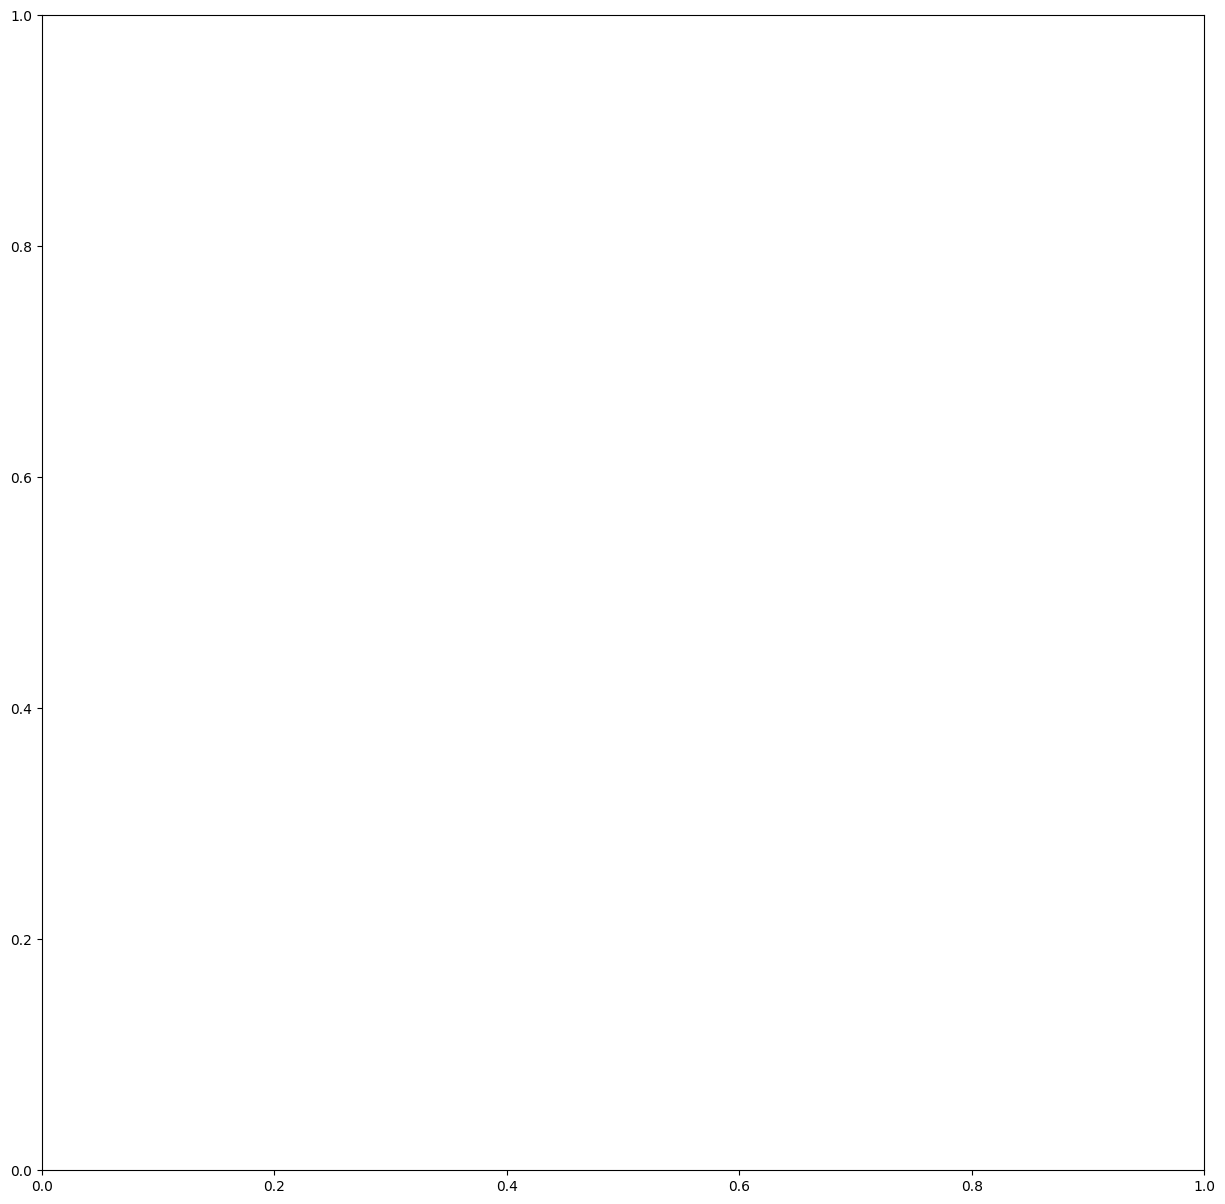

In [24]:
from supervised.automl import AutoML

mljar = AutoML(mode = "Perform", results_path = output_folder+"MLjar")
mljar.fit(x_train, y_train)

C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a


 
              precision    recall  f1-score   support

         0.0       0.70      0.58      0.63        33
         1.0       0.64      0.76      0.69        33

    accuracy                           0.67        66
   macro avg       0.67      0.67      0.66        66
weighted avg       0.67      0.67      0.66        66



C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a

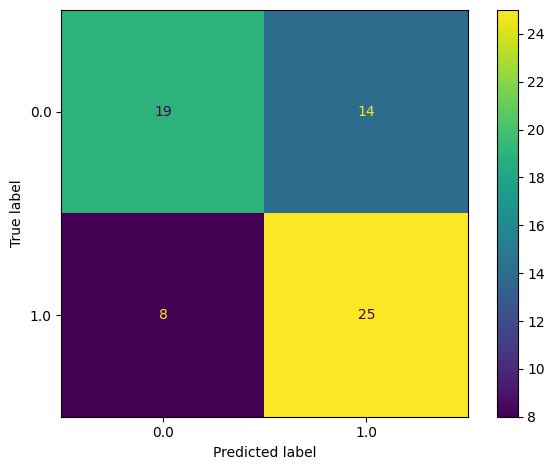

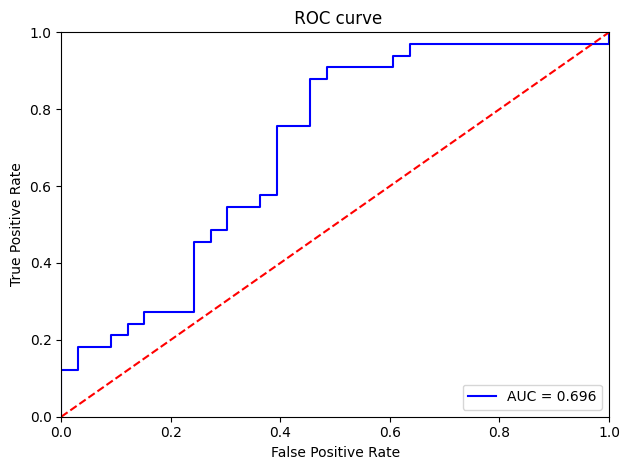

In [25]:
report_utils.classification_summary(y_valid, mljar.predict_proba(x_valid)[:, 1])

# Output

In [26]:
# Save the result ro output_path
important_feature.to_csv(output_folder + export_title + " important feature.csv")
importance.to_csv(output_folder+export_title+ " importance.csv")

In [27]:
import joblib
# save model
joblib.dump(rf, output_folder+"models/"+export_title+"RandomForest")
joblib.dump(svm, output_folder+"models/"+export_title+"SVM")

['./output/models/example_basic SVM']


 
              precision    recall  f1-score   support

         0.0       0.68      0.58      0.62        33
         1.0       0.63      0.73      0.68        33

    accuracy                           0.65        66
   macro avg       0.66      0.65      0.65        66
weighted avg       0.66      0.65      0.65        66



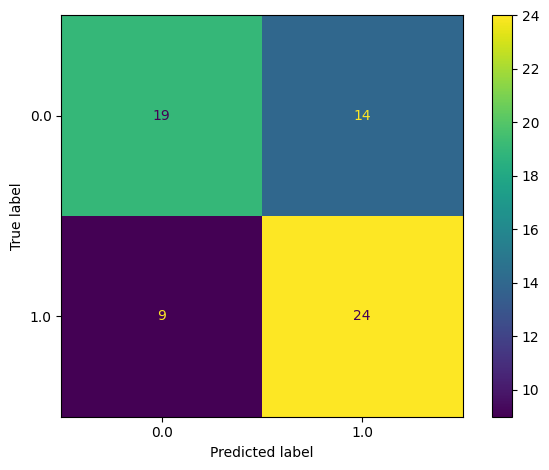

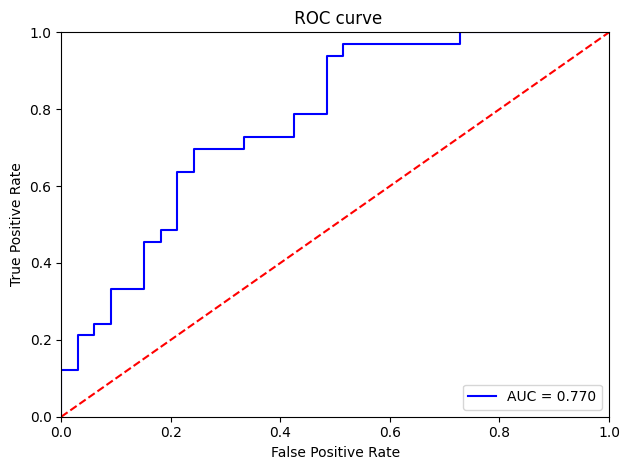

In [28]:
# load model
presaved_model = joblib.load(output_folder+"models/"+export_title+"SVM")
report_utils.classification_summary(y_valid, presaved_model.predict_proba(x_valid)[:, 1]) 